# Data Exploration - 6

## Carga de datos - 1
Se realiza carga de datos obtenidos mediante web crawling a pollstar.com

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from pandas.plotting import lag_plot
import numpy  as np

In [78]:
# Se utiliza para agregar campo pais a la data cargada
def separator(x):
    ciudad, estado_pais = x.split(',', 1)
    if (len(estado_pais.strip()) == 2):
        estado_pais = "USA"
    elif ("Canada" in estado_pais):
         estado_pais = "Canada"
    return ciudad.strip(), estado_pais.strip()

In [79]:
filename = "/home/bberrios/experimento-1/filtrar/live_boxoffice-all-2.txt"
dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')
events = pd.read_csv(filename, sep='\t', parse_dates=['StartPlayDate'], date_parser=dateparse)
events['city'], events['country'] = zip(*events['cityStateCountry'].apply(separator))
events.head()

,StartPlayDate,sortName,eventName,venue,cityStateCountry,numTicketSold,capacity,capacityPercentage,ticketPriceFrom,ticketriceTo,grossUSD,currency,grossGate,numShows,city,country
0,2018-05-05,KENNY CHESNEY,Kenny Chesney,U.S. Bank Stadium,"Minneapolis, MN",48255,48255,100,29.00,260.00,4999184,US DOLLAR,4999184,1,Minneapolis,USA
1,2018-05-04,FOO FIGHTERS,Foo Fighters,Bridgestone Arena,"Nashville, TN",13537,13537,100,49.00,99.00,1264443,US DOLLAR,1264443,1,Nashville,USA
2,2018-05-02,SPRINGSTEEN ON BROADWAY,Springsteen On Broadway / Bruce Springsteen,Walter Kerr Theatre,"New York, NY",3792,948,100,75.00,850.00,1928605,US DOLLAR,1928605,4,New York,USA
3,2018-05-01,DON BROCO,Don Broco,Keele University,"Keele, United Kingdom",797,1100,73,25.00,28.00,27432,UK Pounds,19937,1,Keele,United Kingdom
4,2018-05-01,DARYL HALL JOHN OATES,Daryl Hall & John Oates / Train,Golden 1 Center,"Sacramento, CA",8840,10259,87,45.97,125.97,650141,US DOLLAR,650141,1,Sacramento,USA


## Carga de datos - 2
Se cargan datos obtenidos desde musicbrainz.org

In [80]:
filename_styles = "/home/bberrios/experimento-1/estilos-ultima-version.txt"
styles = pd.read_csv(filename_styles, sep=';')
styles.head()

,artist,style
0,"McKnight, Brian","adult contemporary,contemporary r&b,pop,r&b,soul"
1,NOT3S,NaN
2,WHITNEY TAI,NaN
3,BREEDERS,"4ad,alternative rock,american,rock and indie,usa"
4,CHEESE ON BREAD,NaN


In [81]:
clean_styles = styles.dropna(subset = ['style'])

In [82]:
list_styles_artist = []
for index, row in clean_styles.iterrows():
    st_list = row['style'].split(",")
    for s in st_list:
        list_styles_artist.append({'artist' : row['artist'],'style': s.strip()})


styles_df = pd.DataFrame(list_styles_artist) 
styles_df.head()
    

,artist,style
0,"McKnight, Brian",adult contemporary
1,"McKnight, Brian",contemporary r&b
2,"McKnight, Brian",pop
3,"McKnight, Brian",r&b
4,"McKnight, Brian",soul


In [83]:
Se unen las 2 fuentes de datos en un "inner join"

SyntaxError: invalid syntax (<ipython-input-83-28152b139a20>, line 1)

In [84]:
joined = styles_df.merge(
    events, 
    left_on=['artist'], 
    right_on=['sortName'], 
    how='inner', 
    indicator=False)
joined = joined.fillna(0)
joined[:10]

,artist,style,StartPlayDate,sortName,eventName,venue,cityStateCountry,numTicketSold,capacity,capacityPercentage,ticketPriceFrom,ticketriceTo,grossUSD,currency,grossGate,numShows,city,country
0,"McKnight, Brian",adult contemporary,2018-02-10,"McKnight, Brian",Brian McKnight,Crown Theatre,"Fayetteville, NC",1080,2442,45,48.0,100.0,64062,US DOLLAR,64062,1,Fayetteville,USA
1,"McKnight, Brian",contemporary r&b,2018-02-10,"McKnight, Brian",Brian McKnight,Crown Theatre,"Fayetteville, NC",1080,2442,45,48.0,100.0,64062,US DOLLAR,64062,1,Fayetteville,USA
2,"McKnight, Brian",pop,2018-02-10,"McKnight, Brian",Brian McKnight,Crown Theatre,"Fayetteville, NC",1080,2442,45,48.0,100.0,64062,US DOLLAR,64062,1,Fayetteville,USA
3,"McKnight, Brian",r&b,2018-02-10,"McKnight, Brian",Brian McKnight,Crown Theatre,"Fayetteville, NC",1080,2442,45,48.0,100.0,64062,US DOLLAR,64062,1,Fayetteville,USA
4,"McKnight, Brian",soul,2018-02-10,"McKnight, Brian",Brian McKnight,Crown Theatre,"Fayetteville, NC",1080,2442,45,48.0,100.0,64062,US DOLLAR,64062,1,Fayetteville,USA
5,BREEDERS,4ad,2018-04-10,BREEDERS,The Breeders,McMenamins Crystal Ballroom,"Portland, OR",1425,1425,100,25.0,28.0,35670,US DOLLAR,35670,1,Portland,USA
6,BREEDERS,alternative rock,2018-04-10,BREEDERS,The Breeders,McMenamins Crystal Ballroom,"Portland, OR",1425,1425,100,25.0,28.0,35670,US DOLLAR,35670,1,Portland,USA
7,BREEDERS,american,2018-04-10,BREEDERS,The Breeders,McMenamins Crystal Ballroom,"Portland, OR",1425,1425,100,25.0,28.0,35670,US DOLLAR,35670,1,Portland,USA
8,BREEDERS,rock and indie,2018-04-10,BREEDERS,The Breeders,McMenamins Crystal Ballroom,"Portland, OR",1425,1425,100,25.0,28.0,35670,US DOLLAR,35670,1,Portland,USA
9,BREEDERS,usa,2018-04-10,BREEDERS,The Breeders,McMenamins Crystal Ballroom,"Portland, OR",1425,1425,100,25.0,28.0,35670,US DOLLAR,35670,1,Portland,USA


## Análisis de éxito por estilo

In [85]:
styles_grouped = joined.groupby('style', as_index = False)
styles_grouped_aggregate = styles_grouped['capacityPercentage'].agg(['mean', 'std','count']).replace(np.nan, 0, regex=True)
styles_grouped_aggregate = styles_grouped_aggregate.reset_index()

success_styles = styles_grouped_aggregate[styles_grouped_aggregate['mean'] >= 80]
gt_50_count = success_styles[success_styles['count'] > 40]
gt_50_count.sort_values(by = ['mean', 'count'], ascending = [0,0])[:10]

,style,mean,std,count
130,dance-pop,93.555556,12.705682,45
294,latin,91.615385,14.321455,52
115,contemporary country,89.571429,15.204166,49
71,british,87.822222,20.563968,45
257,indie pop,87.448980,15.543033,49
369,pop,87.034014,17.373186,147
376,pop rock,86.475138,16.160847,181
196,folk rock,86.404255,19.910298,47
22,american,85.691489,19.393507,94
432,rock,85.594340,19.453324,212


Estilos musicales de las bandas que tuvieron éxito considerando solo estilos que tuvieron más de 40 coincidencias con eventos.

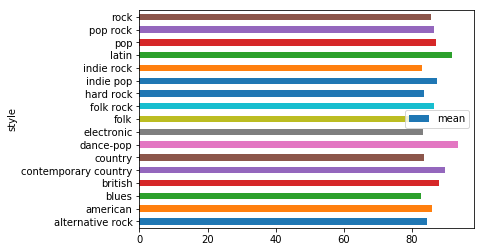

In [86]:
gt_50_count.plot(kind = 'barh', x = 'style', y = 'mean')

## Análisis de éxito por estilo v/s lugar del evento

In [87]:
styles_grouped_city = joined.groupby(['style', 'cityStateCountry'], as_index = False)
styles_grouped_city_aggregate = styles_grouped_city['capacityPercentage'].agg(['mean', 'std','count']).replace(np.nan, 0, regex=True)
styles_grouped_city_aggregate = styles_grouped_city_aggregate.reset_index()

success_styles_city = styles_grouped_city_aggregate[styles_grouped_city_aggregate['mean'] >= 80]
success_count_4 = success_styles_city[success_styles_city['count'] > 4]
success_count_4

,style,cityStateCountry,mean,std,count
149,alternative rock,"Chicago, IL",89.200000,22.509998,5
435,blues,"Boston, MA",82.800000,20.861448,5
594,british,"Dublin, Ireland",92.600000,7.924645,5
985,contemporary r&b,"Las Vegas, NV",99.333333,1.632993,6
1051,country,"New York, NY",87.800000,27.280029,5
1170,dance,"Las Vegas, NV",99.200000,1.788854,5
1191,dance-pop,"Las Vegas, NV",94.428571,13.062123,7
1311,electro house,"Las Vegas, NV",99.200000,1.788854,5
1335,electronic,"Las Vegas, NV",98.166667,2.994439,6
1345,electronic,"Montreal, QC, Canada",91.200000,8.228001,5


In [88]:
pd.set_option('display.width', 20000)
city_styles = {}
for index, row in success_count_4.iterrows():
    city = row['cityStateCountry']
    style = row['style']
    if city not in city_styles:
        city_styles[city] = [style]
    else:
         city_styles[city].append(style)

city_styles_temp = []
for index, value in city_styles.iteritems():
    city_styles_temp.append({'location' : index, 'styles' : ','.join(value)}) 
    
pd.DataFrame(city_styles_temp)

,location,styles
0,"Austin, TX",rock
1,"Boston, MA","blues,pop,rock"
2,"Chicago, IL","alternative rock,folk,rock"
3,"Montreal, QC, Canada",electronic
4,"Las Vegas, NV","contemporary r&b,dance,dance-pop,electro house..."
5,"Newark, NJ",pop
6,"Washington, DC",rock
7,"New York, NY","country,folk,rock and indie"
8,"Dublin, Ireland",british
9,"Brussels, Belgium",rock
